# Signed Graph Convolutional Network(SGCN)を用いたFraud User Detection

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
os.chdir('gdrive/My Drive/SGCN/src')

In [0]:
!pip install torch_scatter
!pip install torch_sparse
!pip install easydict
!pip install texttable
!pip install networkx==1.11
!pip install tqdm==4.28.1
!pip install numpy==1.15.4
!pip install pandas==0.23.4
!pip install texttable==1.5.0
!pip install scipy==1.1.0
!pip install argparse==1.1.0
!pip install sklearn
!pip install torch
!pip install torch-geometric==0.3.1
!pip install torchvision==0.2.1

In [0]:
from sgcn_master import SignedGCNTrainer, SignedGCNPredictor
from parser import parameter_parser
from utils import tab_printer, read_graph, score_printer, save_logs
import easydict
import argparse
import pandas as pd
import numpy as np
import torch
import json
import networkx as nx
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
data_name = input('データセット：')

データセット：alpha


In [0]:
args = easydict.EasyDict({
        "edge_path": '../input/{0}/{0}_network.csv'.format(data_name),
        "features_path":  '../input/{0}/{0}_node_feature.csv'.format(data_name),
        "nodes_path": '../input/{0}/{0}_gt.csv'.format(data_name),
        "embedding_path": '../tmp/embedding/{0}_sgcn_feature05.pkl'.format(data_name), 
        "regression_weights_path": '../tmp/weights/{0}_sgcn_feature05.pkl'.format(data_name),
        "inductive_model_path": None, # '/home2/kudo/SGCN/output/inductive/{0}_model'.format(data_name), # or None
        "log_path": '../logs/{0}_logs_feature05.json'.format(data_name),
        "epochs":150,
        "test_size":0.33,
        "reduction_iterations": 128,
        "reduction_dimensions": 30,
        "seed": 42,
        "lamb": 0.0,
        "learning_rate": 0.001,  
        "weight_decay": 10e-4, 
        # "layers": [64, 32,16,8],
        "layers": [32,16,],
        "spectral_features":False,
        "general_features": True,  
        "sample_num":None,
        "class_weights":False,
        "node_under_sampling":False,
        "hidden_residual":False,
        "eval_freq":1,
        "subgraph_training":False
})

In [0]:
display(pd.io.json.json_normalize(args).T)

,0
class_weights,False
edge_path,../input/alpha/alpha_network.csv
embedding_path,../tmp/embedding/alpha_sgcn_feature05.pkl
epochs,150
eval_freq,1
features_path,../input/alpha/alpha_node_feature.csv
general_features,True
hidden_residual,False
inductive_model_path,None
lamb,0


## 10-fold cross-validation
- train : validation : test = 6:3:1

In [0]:
#tab_printer(args)
edges, nodes_dict = read_graph(args) # nodes_dict['indice']:node_id , nodes_dict['label'] : label

In [0]:
# undirected
edges['positive_edges'] = edges['positive_edges'] + [[d,s] for s,d in edges['positive_edges']]
edges['negative_edges'] = edges['negative_edges'] + [[d,s] for s,d in edges['negative_edges']]

In [0]:
from sklearn.model_selection import StratifiedKFold

In [0]:
kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
all_indice = nodes_dict['indice']
all_labels = nodes_dict['label']
auc_scores = []

In [0]:
for i, (test_index, train_index) in enumerate(kf.split(X=nodes_dict['indice'],y=nodes_dict['label'])):
    print("==== Training Phase ====")
    print('{}-th fold'.format(i))
    # training
    train_node_indice = all_indice[train_index]
    train_node_labels = all_labels[train_index]
    print('labels:{}'.format(np.unique(train_node_labels,return_counts=True)))
    tmp_nodes_dict = {}
    tmp_nodes_dict['all_ncount'] = nodes_dict['all_ncount']
    tmp_nodes_dict['indice'] = train_node_indice
    tmp_nodes_dict['label'] = train_node_labels
    trainer = SignedGCNTrainer(args, edges, tmp_nodes_dict)
    trainer.setup_dataset()
    trainer.create_and_train_model()
    
    if args.test_size > 0:
        # trainer.save_model() ## trainer.create_and_train_model()のなかで，すでにbest_modelが保存されている．
        # score_printer(trainer.logs)
        display(pd.DataFrame(trainer.logs['performance']))
        save_logs(args, trainer.logs)

    # test
    print("==== Test Phase ====")
    test_node_indice = all_indice[test_index]
    test_node_labels = all_labels[test_index]
    # feature = pd.read_csv(args.embedding_path,index_col='id').values
    feature = pd.read_pickle(args.embedding_path).drop('id',1).values
    test_feature = feature[test_node_indice]
    # weight = pd.read_csv(args.regression_weights_path)
    weight = pd.read_pickle(args.regression_weights_path)
    predictions = np.dot(test_feature,weight.values.T)
    probabilities = torch.nn.functional.softmax(torch.from_numpy(predictions)).numpy()
    predict_labels = probabilities.argmax(1)
    auc_score = roc_auc_score(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_score=probabilities[:,1])
    auc_scores.append(auc_score)
    cmx = confusion_matrix(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_pred=predict_labels)
    print("{0}-th fold's auc_score:{1}".format(i,auc_score))
    print(cmx)
    print()

In [0]:
np.mean(auc_scores)

0.9084703620362806

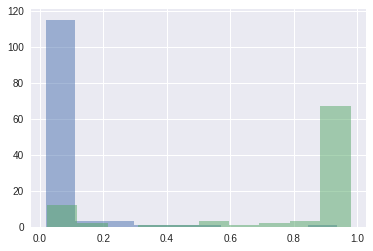

In [0]:
_ = plt.hist(probabilities[:,1][test_node_labels==1],alpha=0.5,bins=10)
_ = plt.hist(probabilities[:,1][test_node_labels==-1],alpha=0.5,bins=10)
# plt.xlim(0,0.03)

## new_new_balance_theoryの結果
結果 (32,) (non-class-weights,10e-4, test_size=0.33,lamb=0,lr=0.001)　⬅️これに決定
- amazon :  0.8655989752374083
- alpha : 0.974480519480
- otc : 0.99349

結果 (32,16) (non-class-weights,10e-4, test_size=0.33,lamb=0,lr=0.001)　
- amazon :  0.876279480706
- alpha : 0.977922077922
- otc : 0.99072039072
- epinions : 0.9768200116


結果 (32,16, 8) (non-class-weights,10e-4, test_size=0.33, lamb=0)
- amazon : 0.8786657350643106
- alpha : 
- otc : 

結果 (32,16, 8, 8) (non-class-weights,10e-4, test_size=0.33, lamb=0)
- amazon : 0.8778590500661
- alpha : 
- otc : 



## single-validation

In [0]:
data_name = input('データセット：')

In [0]:
args = easydict.EasyDict({
        "edge_path": f'../input/{data_name}/{data_name}_network.csv',
        "features_path":  f'../input/{data_name}/{data_name}_node_feature.csv',
        "nodes_path": f'../input/{data_name}/{data_name}_gt.csv',
        "embedding_path": f'../tmp/embedding/{data_name}_sgcn_feature05.pkl', # tmp folder for cross-validation
        "regression_weights_path": f'../tmp/weights/{data_name}_sgcn_feature05.pkl',
        "inductive_model_path": f'../output/inductive/{data_name}_model', # or None
        "log_path": f'../logs/{data_name}_logs_feature05.json',
        "epochs":300,
        "test_size":0.33,
        "reduction_iterations": 128,
        "reduction_dimensions": 30,
        "seed": 42,
        "lamb": 0.0,
        "learning_rate": 0.001,  
        "weight_decay": 10e-4, 
        # "layers": [64, 32,16,8],
        "layers": [32, 16, 8],
        "spectral_features":False,
        "general_features": True,  
        "sample_num":None,
        "class_weights":False,
        "node_under_sampling":False,
        "hidden_residual":False,
        "eval_freq":1,
        "subgraph_training":False,
})

In [0]:
#tab_printer(args)
edges, nodes_dict = read_graph(args) # nodes_dict['indice']:node_id , nodes_dict['label'] : label
# undirected
edges['positive_edges'] = edges['positive_edges'] + [[d,s] for s,d in edges['positive_edges']]
edges['negative_edges'] = edges['negative_edges'] + [[d,s] for s,d in edges['negative_edges']]

In [0]:
trainer = SignedGCNTrainer(args, edges, nodes_dict)
trainer.setup_dataset()
trainer.create_and_train_model()

In [0]:
if args.test_size > 0:
    trainer.save_model()
    # score_printer(trainer.logs)
    display(pd.DataFrame(trainer.logs['performance']))
    save_logs(args, trainer.logs)

## inductive prediction

In [0]:
data_name = input('データセット：')

In [0]:
new_args = easydict.EasyDict({
        "edge_path": f'../input/{data_name}/{data_name}_network.csv',
        "features_path":  f'../input/{data_name}/{data_name}_node_feature.csv',
        "nodes_path": f'../input/{data_name}/{data_name}_gt.csv',
        "embedding_path": f'../tmp/embedding/{data_name}_sgcn_feature05.pkl', # tmp folder for cross-validation
        "regression_weights_path": f'../tmp/weights/{data_name}_sgcn_feature05.pkl',
        "inductive_model_path": f'../output/inductive/{data_name}_model', # or None
        "log_path": f'../logs/{data_name}_logs_feature05.json',
        "epochs":300,
        "test_size":0.33,
        "reduction_iterations": 128,
        "reduction_dimensions": 30,
        "seed": 42,
        "lamb": 0.0,
        "learning_rate": 0.001,  
        "weight_decay": 10e-4, 
        # "layers": [64, 32,16,8],
        "layers": [32, 16, 8],
        "spectral_features":False,
        "general_features": True,  
        "sample_num":None,
        "class_weights":False,
        "node_under_sampling":False,
        "hidden_residual":False,
        "eval_freq":1,
        "subgraph_training":False,
})

In [0]:
new_edges, new_nodes_dict = read_graph(new_args)
# undirected
new_edges['positive_edges'] = new_edges['positive_edges'] + [[d,s] for s,d in new_edges['positive_edges']]
new_edges['negative_edges'] = new_edges['negative_edges'] + [[d,s] for s,d in new_edges['negative_edges']]
X = np.array(pd.read_csv(f'../input/{data_name}/{data_name}_node_feature.csv')) # general node features

In [0]:
training_dataset = input('学習に使ったデータセット：')

In [0]:
predictor = SignedGCNPredictor(new_args, f'../output/inductive/{training_dataset}_model', X, new_edges,new_nodes_dict)

In [0]:
predictions = predictor.predict()
predict_labels = predictions.argmax(1)

In [0]:
y_true = new_nodes_dict['label']

roc_auc_score(y_true=[1 if i==-1 else 0 for i in new_nodes_dict['label']],y_score=predictions[:,1][new_nodes_dict['indice']])

In [0]:
from sklearn.metrics import accuracy_score,confusion_matrix
confusion_matrix([1 if i==-1 else 0 for i in new_nodes_dict['label']],predict_labels[new_nodes_dict['indice']])

In [0]:
_ = plt.hist(predictions[:,1][new_nodes_dict['indice']][y_true==1],alpha=0.5,bins=10)
_ = plt.hist(predictions[:,1][new_nodes_dict['indice']][y_true==-1],alpha=0.5,bins=10)

## epinions dataset

In [0]:
data_name = 'epinions'

In [0]:
args = easydict.EasyDict({
        "edge_path": '../input/{0}/{0}_network.csv'.format(data_name),
        "features_path":  '../input/{0}/{0}_node_feature.csv'.format(data_name),
        "nodes_path": '../input/{0}/{0}_gt.csv'.format(data_name),
        "embedding_path": '../tmp/embedding/{0}_sgcn_feature05.pkl'.format(data_name), 
        "regression_weights_path": '../tmp/weights/{0}_sgcn_feature05.pkl'.format(data_name),
        "inductive_model_path": '../output/inductive/{}_model'.format(data_name), # or None
        "log_path": '../logs/{0}_logs_feature05.json'.format(data_name),
        "epochs":150,
        "test_size":0.33,
        "reduction_iterations": 128,
        "reduction_dimensions": 30,
        "seed": 42,
        "lamb": 0.0,
        "learning_rate": 0.001,  
        "weight_decay": 10e-4, 
        # "layers": [64, 32,16,8],
        "layers": [32,16,],
        "spectral_features":False,
        "general_features": True,  
        "sample_num":None,
        "class_weights":False,
        "node_under_sampling":False,
        "hidden_residual":False,
        "eval_freq":1,
        "subgraph_training":False
})

In [0]:
display(pd.io.json.json_normalize(args).T)

,0
class_weights,False
edge_path,../input/epinions/epinions_network.csv
embedding_path,../tmp/embedding/epinions_sgcn_feature05.pkl
epochs,150
eval_freq,1
features_path,../input/epinions/epinions_node_feature.csv
general_features,True
hidden_residual,False
inductive_model_path,../output/inductive/epinions_model
lamb,0


In [0]:
#tab_printer(args)
edges, nodes_dict = read_graph(args) # nodes_dict['indice']:node_id , nodes_dict['label'] : label

In [0]:
# undirected
edges['positive_edges'] = edges['positive_edges'] + [[d,s] for s,d in edges['positive_edges']]
edges['negative_edges'] = edges['negative_edges'] + [[d,s] for s,d in edges['negative_edges']]

In [0]:
test_X = np.array(pd.read_csv(args.features_path))

In [0]:
def subgraph_making(args,edges,nodes_dict,sample_node_num,train_node_indice_original,neighbor_sampling=True):
    original_network_df = pd.read_csv(args.edge_path)
    if neighbor_sampling == True:
        first_neightbors = np.unique(original_network_df.loc[(original_network_df.id1_.isin(train_node_indice_original)) | 
                                                                                                      (original_network_df.id2_.isin(train_node_indice_original)), ['id1_','id2_']].values)
        sampled_node_indice = np.random.choice(first_neightbors,sample_node_num,replace=False)
    else:
        sampled_node_indice = set(np.random.choice(np.arange(nodes_dict['all_ncount']), sample_node_num, replace=False)) | set(train_node_indice_original)

    sub_network_df = \
        original_network_df.loc[(original_network_df.id1_.isin(sampled_node_indice)) & (original_network_df.id2_.isin(sampled_node_indice))]

    original_gt_df = pd.read_csv(args.nodes_path)

    sub_gt_df = \
        original_gt_df.copy().loc[(original_gt_df.node_id.isin(sub_network_df.id1_)) & (original_gt_df.node_id.isin(sub_network_df.id2_))]

    from sklearn.preprocessing import LabelEncoder

    subGraph_map_encoder = LabelEncoder()

    subGraph_map_encoder.fit(list(set(sub_network_df.id1_) | set(sub_network_df.id2_) | set(sub_gt_df.node_id)))

    sub_gt_df['node_id'] = subGraph_map_encoder.transform(sub_gt_df.node_id)

    sub_network_df['id1_'] = subGraph_map_encoder.transform(sub_network_df.id1_)

    sub_network_df['id2_'] = subGraph_map_encoder.transform(sub_network_df.id2_)

    sub_edges = {}

    sub_edges['positive_edges'] = sub_network_df.loc[sub_network_df.weight==1,['id1_','id2_']].values.tolist()

    sub_edges['negative_edges'] = sub_network_df.loc[sub_network_df.weight==-1,['id1_','id2_']].values.tolist()

    sub_edges['ecount'] = len(sub_network_df)

    sub_edges['ncount'] = len(set(sub_network_df['id1_']) | set(sub_network_df['id2_']))

    sub_nodes_dict = {}

    sub_nodes_dict['indice'] = sub_gt_df.node_id.values
    sub_nodes_dict['label'] = sub_gt_df.label.values

    sub_nodes_dict['all_ncount'] = len(set(sub_network_df.id1_) | set(sub_network_df.id2_) | set(sub_gt_df.node_id))

    sub_nodes_dict['subgraph_map_from_original_feature'] = subGraph_map_encoder.classes_    
    return sub_edges, sub_nodes_dict, subGraph_map_encoder

In [0]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=True, random_state=0)
all_indice = nodes_dict['indice']
all_labels = nodes_dict['label']

In [0]:
auc_scores = []
# train : 90 % cross-validation
for i, (train_index, test_index) in enumerate(kf.split(X=nodes_dict['indice'],y=nodes_dict['label'])):
    print("==== Training Phase ====")
    print(f'{i}-th fold')
    # training
    train_node_indice_original = all_indice[train_index] #⬅️これは元々のグラフのnode_indice

    # extract sub-graph
    sub_edges, sub_nodes_dict,subGraph_map_encoder = subgraph_making(args,edges,nodes_dict,20000, train_node_indice_original)
                                                                     # np.random.choice(train_node_indice_original,1000))
    
    train_indice_boolean_judger = np.isin(subGraph_map_encoder.inverse_transform(sub_nodes_dict['indice']),train_node_indice_original)
    train_node_indice = sub_nodes_dict['indice'][train_indice_boolean_judger]
    train_node_labels = sub_nodes_dict['label'][train_indice_boolean_judger]
    print(f'labels:{np.unique(train_node_labels,return_counts=True)}')
    tmp_nodes_dict = {}
    tmp_nodes_dict['all_ncount'] = sub_nodes_dict['all_ncount']
    tmp_nodes_dict['indice'] = train_node_indice
    tmp_nodes_dict['label'] = train_node_labels
    tmp_nodes_dict['subgraph_map_from_original_feature'] = subGraph_map_encoder.classes_
    trainer = SignedGCNTrainer(args, sub_edges, tmp_nodes_dict)
    trainer.setup_dataset()
    trainer.create_and_train_model()
    
    if args.test_size > 0:
        # trainer.save_model() ## trainer.create_and_train_model()のなかで，すでにbest_modelが保存されている．
        # score_printer(trainer.logs)
        display(pd.DataFrame(trainer.logs['performance']))
        save_logs(args, trainer.logs)

    # test
    print("==== Test Phase ====")
    test_node_indice = all_indice[test_index]
    test_node_labels = all_labels[test_index]
    predictor = SignedGCNPredictor(args, args.inductive_model_path, test_X, edges,nodes_dict)
    predictions = predictor.predict()
    predict_labels = predictions.argmax(1)
    auc_score = roc_auc_score(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_score=predictions[:,1][test_node_indice])
    auc_scores.append(auc_score)
    cmx = confusion_matrix(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_pred=predict_labels[test_node_indice])
    print(f"{i}-th fold's auc_score:{auc_score}")
    print(cmx)
    print()
    

In [0]:
np.mean(auc_scores)

## epinions Robustness

In [0]:
all_indice = nodes_dict['indice']
all_labels = nodes_dict['label']

In [0]:
def robustness_experiments(training_rates_list=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    all_auc_scores = []
    done_train_rate = []
    training_rates = training_rates_list
    for train_rate in training_rates:
        print('train_rate : ',train_rate)
        auc_scores = []
        for i in range(10): 
            train_index, test_index = train_test_split(np.arange(len(nodes_dict['indice'])),
                                                       stratify=nodes_dict['label'],train_size=float(train_rate),shuffle=True)

            print("==== Training Phase ====")
            print('{}-th'.format(i))
            # training
            train_node_indice_original = all_indice[train_index] #⬅️これは元々のグラフのnode_indice
            # extract sub-graph
            sub_edges, sub_nodes_dict,subGraph_map_encoder = subgraph_making(args,edges,nodes_dict, 20000, 
                                                                             np.random.choice(train_node_indice_original,1000))
            train_indice_boolean_judger = np.isin(subGraph_map_encoder.inverse_transform(sub_nodes_dict['indice']),train_node_indice_original)
            train_node_indice = sub_nodes_dict['indice'][train_indice_boolean_judger]
            train_node_labels = sub_nodes_dict['label'][train_indice_boolean_judger]

            print('labels:',np.unique(train_node_labels,return_counts=True))
            tmp_nodes_dict = {}
            tmp_nodes_dict['all_ncount'] = sub_nodes_dict['all_ncount']
            tmp_nodes_dict['indice'] = train_node_indice
            tmp_nodes_dict['label'] = train_node_labels
            tmp_nodes_dict['subgraph_map_from_original_feature'] = subGraph_map_encoder.classes_
            trainer = SignedGCNTrainer(args, sub_edges, tmp_nodes_dict)
            trainer.setup_dataset()
            trainer.create_and_train_model()
 
            if args.test_size > 0:
                # trainer.save_model() ## trainer.create_and_train_model()のなかで，すでにbest_modelが保存されている．
                # score_printer(trainer.logs)
                display(pd.DataFrame(trainer.logs['performance']))
                save_logs(args, trainer.logs)

            # test
            print("==== Test Phase ====")
            test_node_indice = all_indice[test_index]
            test_node_labels = all_labels[test_index]
            predictor = SignedGCNPredictor(args, args.inductive_model_path, test_X, edges,nodes_dict)
            predictions = predictor.predict()
            predict_labels = predictions.argmax(1)
            auc_score = roc_auc_score(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_score=predictions[:,1][test_node_indice])
            auc_scores.append(auc_score)
            cmx = confusion_matrix(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_pred=predict_labels[test_node_indice])

            print(i,"-th fold's auc_score:",auc_score)
            print(cmx)
            print()
        all_auc_scores.append(np.mean(auc_scores))
        done_train_rate.append(train_rate)
        print(train_rate , ' -->',np.mean(auc_scores))
        pd.DataFrame(all_auc_scores,index=done_train_rate).to_csv('{}_tmp.csv'.format(data_name))
    return pd.DataFrame(all_auc_scores, index=training_rates, columns=['average_auc'])

In [0]:
epi_result_df = robustness_experiments([0.9,0.8,0.7,0.6,0.5,0.4,0.3])

train_rate :  0.9
==== Training Phase ====
0-th


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


labels: (array([-1,  1]), array([ 103, 1890]))


Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.1801): 100%|██████████| 150/150 [05:57<00:00,  3.19s/it]


,0,1,2
0,Epoch,AUC,F1
1,1,0.574613,0
2,2,0.569146,0
3,3,0.565847,0
4,4,0.561039,0
5,5,0.556137,0
6,6,0.551801,0
7,7,0.549585,0
8,8,0.547794,0
9,9,0.546804,0


==== Test Phase ====


RuntimeError: ignored

In [0]:
epi_result_df.to_csv('epinions_robustness.csv')

In [0]:
epi_result_df.T

In [0]:
!python -V

Python 2.7.15rc1


# ロバストネスの検証

In [8]:
data_name = input('データセット：')

データセット：amazon


In [0]:
args = easydict.EasyDict({
        "edge_path": '../input/{0}/{0}_network.csv'.format(data_name),
        "features_path":  '../input/{0}/{0}_node_feature.csv'.format(data_name),
        "nodes_path": '../input/{0}/{0}_gt.csv'.format(data_name),
        "embedding_path": '../tmp/embedding/{0}_sgcn_feature05.pkl'.format(data_name), 
        "regression_weights_path": '../tmp/weights/{0}_sgcn_feature05.pkl'.format(data_name),
        "inductive_model_path": None, # '/home2/kudo/SGCN/output/inductive/{0}_model'.format(data_name), # or None
        "log_path": '../logs/{0}_logs_feature05.json'.format(data_name),
        "epochs":150,
        "test_size":0.33,
        "reduction_iterations": 128,
        "reduction_dimensions": 30,
        "seed": 42,
        "lamb": 0.0,
        "learning_rate": 0.001,  
        "weight_decay": 10e-4, 
        # "layers": [64, 32,16,8],
        "layers": [32,16,],
        "spectral_features":False,
        "general_features": True,  
        "sample_num":None,
        "class_weights":False,
        "node_under_sampling":False,
        "hidden_residual":False,
        "eval_freq":1,
        "subgraph_training":False
})

In [0]:
#tab_printer(args)
edges, nodes_dict = read_graph(args) # nodes_dict['indice']:node_id , nodes_dict['label'] : label

In [0]:
# undirected
edges['positive_edges'] = edges['positive_edges'] + [[d,s] for s,d in edges['positive_edges']]
edges['negative_edges'] = edges['negative_edges'] + [[d,s] for s,d in edges['negative_edges']]

In [0]:
all_indice = nodes_dict['indice']
all_labels = nodes_dict['label']

In [0]:
def robustness_experiments(training_rates_list=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    all_auc_scores = []
    training_rates = training_rates_list
    for train_rate in training_rates:
        auc_scores = []
        for i in range(10): 
            train_index, test_index = train_test_split(np.arange(len(nodes_dict['indice'])),
                                                       stratify=nodes_dict['label'],train_size=float(train_rate),shuffle=True)
            print("==== Training Phase ====")
            print('{}-th'.format(i))
            # training
            train_node_indice = all_indice[train_index]
            train_node_labels = all_labels[train_index]
            print('labels:{}'.format(np.unique(train_node_labels,return_counts=True)))
            tmp_nodes_dict = {}
            tmp_nodes_dict['all_ncount'] = nodes_dict['all_ncount']
            tmp_nodes_dict['indice'] = train_node_indice
            tmp_nodes_dict['label'] = train_node_labels
            trainer = SignedGCNTrainer(args, edges, tmp_nodes_dict)
            trainer.setup_dataset()
            trainer.create_and_train_model()

            if args.test_size > 0:
                # trainer.save_model() ## trainer.create_and_train_model()のなかで，すでにbest_modelが保存されている．
                # score_printer(trainer.logs)
                display(pd.DataFrame(trainer.logs['performance']))
                save_logs(args, trainer.logs)

            # test
            print("==== Test Phase ====")
            test_node_indice = all_indice[test_index]
            test_node_labels = all_labels[test_index]
            # feature = pd.read_csv(args.embedding_path,index_col='id').values
            feature = pd.read_pickle(args.embedding_path).drop('id',1).values
            test_feature = feature[test_node_indice]
            # weight = pd.read_csv(args.regression_weights_path)
            weight = pd.read_pickle(args.regression_weights_path)
            predictions = np.dot(test_feature,weight.values.T)
            probabilities = torch.nn.functional.softmax(torch.from_numpy(predictions)).numpy()
            predict_labels = probabilities.argmax(1)
            auc_score = roc_auc_score(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_score=probabilities[:,1])
            auc_scores.append(auc_score)
            cmx = confusion_matrix(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_pred=predict_labels)
            print("{0}-th fold's auc_score:{1}".format(i ,auc_score))
            print(cmx)
            print()
        all_auc_scores.append(np.mean(auc_scores))
        print(train_rate,':',np.mean(auc_scores))
        pd.DataFrame(all_auc_scores).to_csv('{}_tmp.csv'.format(data_name+'_master'))
    return pd.DataFrame(all_auc_scores, index=training_rates, columns=['average_auc'])

In [0]:
result_df = robustness_experiments([0.03, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


==== Training Phase ====
0-th
labels:(array([-1,  1]), array([ 7, 70]))


Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.0487): 100%|██████████| 150/150 [02:11<00:00,  1.08it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.916667,0
2,2,0.958333,0
3,3,0.958333,0
4,4,0.958333,0
5,5,0.958333,0
6,6,0.958333,0
7,7,0.958333,0
8,8,0.958333,0
9,9,0.958333,0


==== Test Phase ====
0-th fold's auc_score:0.8100354506604507
[[2092  196]
 [ 148   86]]

==== Training Phase ====
1-th
labels:(array([-1,  1]), array([ 7, 70]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.1554): 100%|██████████| 150/150 [02:04<00:00,  1.79it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.6875,0
2,2,0.6875,0
3,3,0.8125,0
4,4,0.875,0
5,5,0.895833,0
6,6,0.916667,0
7,7,0.875,0
8,8,0.8125,0
9,9,0.770833,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


==== Test Phase ====
1-th fold's auc_score:0.7533909733428964
[[2254   34]
 [ 174   60]]

==== Training Phase ====
2-th
labels:(array([-1,  1]), array([ 7, 70]))


Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.0974): 100%|██████████| 150/150 [01:23<00:00,  1.82it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.833333,0
2,2,0.854167,0
3,3,0.875,0
4,4,0.916667,0
5,5,0.895833,0
6,6,0.895833,0
7,7,0.875,0
8,8,0.854167,0
9,9,0.854167,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


==== Test Phase ====
2-th fold's auc_score:0.7896784038610961
[[2288    0]
 [ 234    0]]

==== Training Phase ====
3-th
labels:(array([-1,  1]), array([ 7, 70]))


Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.1453): 100%|██████████| 150/150 [02:10<00:00,  1.06it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.427083,0
2,2,0.40625,0
3,3,0.46875,0
4,4,0.53125,0
5,5,0.53125,0
6,6,0.78125,0
7,7,0.802083,0
8,8,0.822917,0
9,9,0.84375,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


==== Test Phase ====
3-th fold's auc_score:0.8057049787819018

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
Loss:   0%|          | 0/150 [00:00<?, ?it/s]


[[2183  105]
 [ 192   42]]

==== Training Phase ====
4-th
labels:(array([-1,  1]), array([ 7, 70]))

Training started.



SGCN (Loss=0.0924): 100%|██████████| 150/150 [01:55<00:00,  1.83it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.5,0
2,2,0.520833,0
3,3,0.5625,0
4,4,0.583333,0
5,5,0.625,0
6,6,0.729167,0
7,7,0.833333,0
8,8,0.875,0
9,9,0.875,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


==== Test Phase ====
4-th fold's auc_score:0.820339116012193
[[2148  140]
 [ 151   83]]

==== Training Phase ====
5-th
labels:(array([-1,  1]), array([ 7, 70]))


Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.0802): 100%|██████████| 150/150 [02:03<00:00,  1.07s/it]


,0,1,2
0,Epoch,AUC,F1
1,1,0.708333,0
2,2,0.916667,0
3,3,0.958333,0
4,4,0.958333,0
5,5,0.979167,0
6,6,0.979167,0
7,7,0.979167,0
8,8,0.979167,0
9,9,0.979167,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


==== Test Phase ====
5-th fold's auc_score:0.855003436734206
[[2009  279]
 [  77  157]]



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
Loss:   0%|          | 0/150 [00:00<?, ?it/s]

==== Training Phase ====
6-th
labels:(array([-1,  1]), array([ 7, 70]))

Training started.



SGCN (Loss=0.1201): 100%|██████████| 150/150 [01:22<00:00,  1.83it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.895833,0
2,2,0.916667,0
3,3,0.895833,0
4,4,0.875,0
5,5,0.833333,0
6,6,0.854167,0
7,7,0.854167,0
8,8,0.854167,0
9,9,0.833333,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


==== Test Phase ====
6-th fold's auc_score:0.6532484609407686
[[2288    0]
 [ 234    0]]

==== Training Phase ====
7-th
labels:(array([-1,  1]), array([ 7, 70]))


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.0824): 100%|██████████| 150/150 [01:22<00:00,  1.83it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.916667,0
2,2,0.875,0
3,3,0.875,0
4,4,0.875,0
5,5,0.854167,0
6,6,0.833333,0
7,7,0.791667,0
8,8,0.770833,0
9,9,0.75,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


==== Test Phase ====
7-th fold's auc_score:0.6637762611320303
[[2288    0]
 [ 234    0]]

==== Training Phase ====
8-th
labels:(array([-1,  1]), array([ 7, 70]))


Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.0414): 100%|██████████| 150/150 [01:30<00:00,  1.83it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.5625,0
2,2,0.604167,0
3,3,0.625,0
4,4,0.791667,0
5,5,0.791667,0
6,6,0.8125,0
7,7,0.875,0
8,8,0.875,0
9,9,0.875,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


==== Test Phase ====
8-th fold's auc_score:0.8337227676169983
[[2288    0]
 [ 234    0]]

==== Training Phase ====
9-th
labels:(array([-1,  1]), array([ 7, 70]))


Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.0704): 100%|██████████| 150/150 [01:34<00:00,  1.82it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.604167,0
2,2,0.666667,0
3,3,0.6875,0
4,4,0.854167,0
5,5,0.875,0
6,6,0.854167,0
7,7,0.854167,0
8,8,0.875,0
9,9,0.875,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


==== Test Phase ====
9-th fold's auc_score:0.8399864024864026
[[2088  200]
 [ 116  118]]

0.03 : 0.7824886251568943


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


==== Training Phase ====
0-th
labels:(array([-1,  1]), array([ 12, 117]))


Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.0736): 100%|██████████| 150/150 [01:24<00:00,  1.83it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.628205,0
2,2,0.75641,0
3,3,0.775641,0
4,4,0.762821,0
5,5,0.775641,0
6,6,0.775641,0
7,7,0.775641,0
8,8,0.762821,0
9,9,0.75641,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


==== Test Phase ====
0-th fold's auc_score:0.8356658073341401
[[2211   30]
 [ 191   38]]

==== Training Phase ====
1-th
labels:(array([-1,  1]), array([ 12, 117]))


Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.1001): 100%|██████████| 150/150 [01:49<00:00,  1.43it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.294872,0
2,2,0.339744,0
3,3,0.397436,0
4,4,0.474359,0
5,5,0.653846,0
6,6,0.653846,0
7,7,0.679487,0
8,8,0.724359,0
9,9,0.775641,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


==== Test Phase ====
1-th fold's auc_score:0.8565265428526333
[[2184   57]
 [ 151   78]]

==== Training Phase ====
2-th
labels:(array([-1,  1]), array([ 12, 117]))


Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.1124): 100%|██████████| 150/150 [01:33<00:00,  1.82it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.955128,0
2,2,0.967949,0
3,3,0.974359,0
4,4,0.974359,0
5,5,0.974359,0
6,6,0.974359,0
7,7,0.974359,0
8,8,0.974359,0
9,9,0.974359,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


==== Test Phase ====
2-th fold's auc_score:0.8402625543415778
[[2241    0]
 [ 229    0]]

==== Training Phase ====
3-th
labels:(array([-1,  1]), array([ 12, 117]))


Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.0796): 100%|██████████| 150/150 [01:37<00:00,  1.48it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.503205,0
2,2,0.528846,0
3,3,0.695513,0
4,4,0.740385,0
5,5,0.86859,0
6,6,0.88141,0
7,7,0.894231,0
8,8,0.900641,0
9,9,0.907051,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


==== Test Phase ====
3-th fold's auc_score:0.8420971610849024
[[2209   32]
 [ 176   53]]

==== Training Phase ====
4-th
labels:(array([-1,  1]), array([ 12, 117]))


Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.1488): 100%|██████████| 150/150 [01:35<00:00,  1.83it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.846154,0
2,2,0.903846,0
3,3,0.903846,0
4,4,0.903846,0
5,5,0.891026,0
6,6,0.878205,0
7,7,0.871795,0
8,8,0.865385,0
9,9,0.858974,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


==== Test Phase ====
4-th fold's auc_score:0.8378112157509221
[[2174   67]
 [ 205   24]]

==== Training Phase ====
5-th
labels:(array([-1,  1]), array([ 12, 117]))


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.0957): 100%|██████████| 150/150 [01:27<00:00,  1.83it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.730769,0
2,2,0.74359,0
3,3,0.794872,0
4,4,0.814103,0
5,5,0.826923,0
6,6,0.935897,0
7,7,0.948718,0
8,8,0.955128,0
9,9,0.955128,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


==== Test Phase ====
5-th fold's auc_score:0.8477841496992337
[[2241    0]
 [ 229    0]]

==== Training Phase ====
6-th
labels:(array([-1,  1]), array([ 12, 117]))


Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.0773): 100%|██████████| 150/150 [01:25<00:00,  1.83it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.708333,0
2,2,0.753205,0
3,3,0.772436,0
4,4,0.791667,0
5,5,0.830128,0
6,6,0.900641,0
7,7,0.907051,0
8,8,0.919872,0
9,9,0.913462,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


==== Test Phase ====
6-th fold's auc_score:0.8381122744252117
[[2241    0]
 [ 229    0]]

==== Training Phase ====
7-th
labels:(array([-1,  1]), array([ 12, 117]))


Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.1635): 100%|██████████| 150/150 [01:49<00:00,  1.83it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.730769,0
2,2,0.794872,0
3,3,0.801282,0
4,4,0.826923,0
5,5,0.891026,0
6,6,0.897436,0
7,7,0.923077,0
8,8,0.935897,0
9,9,0.942308,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


==== Test Phase ====
7-th fold's auc_score:0.8679979500729751
[[2241    0]
 [ 229    0]]

==== Training Phase ====
8-th
labels:(array([-1,  1]), array([ 12, 117]))


Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.2024): 100%|██████████| 150/150 [01:52<00:00,  1.82it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.512821,0
2,2,0.532051,0
3,3,0.570513,0
4,4,0.608974,0
5,5,0.634615,0
6,6,0.698718,0
7,7,0.717949,0
8,8,0.782051,0
9,9,0.788462,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


==== Test Phase ====
8-th fold's auc_score:0.8143978144504266
[[2146   95]
 [ 160   69]]

==== Training Phase ====
9-th
labels:(array([-1,  1]), array([ 12, 117]))


Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.0739): 100%|██████████| 150/150 [01:23<00:00,  1.83it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.721154,0
2,2,0.714744,0
3,3,0.733974,0
4,4,0.823718,0
5,5,0.836538,0
6,6,0.830128,0
7,7,0.830128,0
8,8,0.823718,0
9,9,0.810897,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


==== Test Phase ====
9-th fold's auc_score:0.7923601246324453
[[2241    0]
 [ 229    0]]

0.05 : 0.8373015594644467
==== Training Phase ====
0-th
labels:(array([-1,  1]), array([ 24, 235]))


Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.2005): 100%|██████████| 150/150 [01:59<00:00,  1.83it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.594551,0
2,2,0.625,0
3,3,0.657051,0
4,4,0.721154,0
5,5,0.75,0
6,6,0.841346,0
7,7,0.854167,0
8,8,0.860577,0
9,9,0.860577,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


==== Test Phase ====
0-th fold's auc_score:0.8501945989828323
[[2035   88]
 [ 170   47]]

==== Training Phase ====
1-th
labels:(array([-1,  1]), array([ 24, 235]))


Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.142): 100%|██████████| 150/150 [01:45<00:00,  1.82it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.552885,0
2,2,0.620192,0
3,3,0.637821,0
4,4,0.653846,0
5,5,0.685897,0
6,6,0.778846,0
7,7,0.799679,0
8,8,0.809295,0
9,9,0.814103,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


==== Test Phase ====
1-th fold's auc_score:0.863772029407998
[[2067   56]
 [ 138   79]]

==== Training Phase ====
2-th
labels:(array([-1,  1]), array([ 24, 235]))


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.1288): 100%|██████████| 150/150 [01:33<00:00,  1.82it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.530449,0
2,2,0.594551,0
3,3,0.625,0
4,4,0.689103,0
5,5,0.705128,0
6,6,0.730769,0
7,7,0.777244,0
8,8,0.799679,0
9,9,0.842949,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


==== Test Phase ====
2-th fold's auc_score:0.8530175323589998
[[2073   50]
 [ 143   74]]

==== Training Phase ====
3-th
labels:(array([-1,  1]), array([ 24, 235]))


Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.1504): 100%|██████████| 150/150 [01:24<00:00,  1.83it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.689103,0
2,2,0.709936,0
3,3,0.717949,0
4,4,0.770833,0
5,5,0.782051,0
6,6,0.774038,0
7,7,0.774038,0
8,8,0.770833,0
9,9,0.754808,0


==== Test Phase ====
3-th fold's auc_score:0.8029622892567905
[[2123    0]
 [ 217    0]]

==== Training Phase ====
4-th
labels:(array([-1,  1]), array([ 24, 235]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.1515): 100%|██████████| 150/150 [01:40<00:00,  1.82it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.748397,0
2,2,0.841346,0
3,3,0.862179,0
4,4,0.913462,0
5,5,0.929487,0
6,6,0.934295,0
7,7,0.94391,0
8,8,0.932692,0
9,9,0.921474,0


==== Test Phase ====
4-th fold's auc_score:0.8499210967872174
[[2089   34]
 [ 167   50]]

==== Training Phase ====
5-th
labels:(array([-1,  1]), array([ 24, 235]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.1958): 100%|██████████| 150/150 [01:26<00:00,  1.83it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.429487,0
2,2,0.498397,0
3,3,0.519231,0
4,4,0.576923,0
5,5,0.634615,0
6,6,0.626603,0
7,7,0.647436,0
8,8,0.676282,0
9,9,0.674679,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


==== Test Phase ====
5-th fold's auc_score:0.8495216967555259
[[2123    0]
 [ 217    0]]

==== Training Phase ====
6-th
labels:(array([-1,  1]), array([ 24, 235]))


Loss:   0%|          | 0/150 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.292):  13%|█▎        | 19/150 [00:16<01:42,  1.27it/s]

In [0]:
result_df.to_csv('{}_robustness.csv'.format(data_name+'_master'))

In [0]:
result_df.T

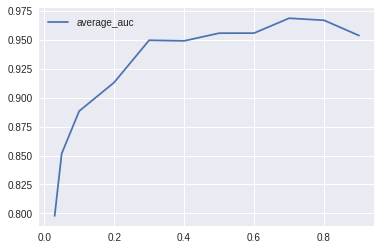

In [0]:
result_df.plot()

In [0]:
train_rate = input('トレーニングデータの比率：')

In [0]:
auc_scores = []
for i in range(10): # trainとtestを逆にする
    train_index, test_index = train_test_split(np.arange(len(nodes_dict['indice'])),stratify=nodes_dict['label'],train_size=float(train_rate)
                                               ,shuffle=True)
    print("==== Training Phase ====")
    print('{}-th'.format(i))
    # training
    train_node_indice = all_indice[train_index]
    train_node_labels = all_labels[train_index]
    print(f'labels:{np.unique(train_node_labels,return_counts=True)}')
    tmp_nodes_dict = {}
    tmp_nodes_dict['all_ncount'] = nodes_dict['all_ncount']
    tmp_nodes_dict['indice'] = train_node_indice
    tmp_nodes_dict['label'] = train_node_labels
    trainer = SignedGCNTrainer(args, edges, tmp_nodes_dict)
    trainer.setup_dataset()
    trainer.create_and_train_model()
    
    if args.test_size > 0:
        # trainer.save_model() ## trainer.create_and_train_model()のなかで，すでにbest_modelが保存されている．
        # score_printer(trainer.logs)
        display(pd.DataFrame(trainer.logs['performance']))
        save_logs(args, trainer.logs)

    # test
    print("==== Test Phase ====")
    test_node_indice = all_indice[test_index]
    test_node_labels = all_labels[test_index]
    # feature = pd.read_csv(args.embedding_path,index_col='id').values
    feature = pd.read_pickle(args.embedding_path).drop('id',1).values
    test_feature = feature[test_node_indice]
    # weight = pd.read_csv(args.regression_weights_path)
    weight = pd.read_pickle(args.regression_weights_path)
    predictions = np.dot(test_feature,weight.values.T)
    probabilities = torch.nn.functional.softmax(torch.from_numpy(predictions)).numpy()
    predict_labels = probabilities.argmax(1)
    auc_score = roc_auc_score(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_score=probabilities[:,1])
    auc_scores.append(auc_score)
    cmx = confusion_matrix(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_pred=predict_labels)
    print("{0}-th fold's auc_score:{1}".format(i,auc_score))
    print(cmx)
    print()
    

In [0]:
np.mean(auc_scores)